In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
from pybullet_envs.bullet.kukaGymEnv import KukaGymEnv
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
import random
import os
from gym import spaces
import time
import pybullet as p
from pybullet_envs.bullet import kuka
import numpy as np
import pybullet_data
import pdb
import distutils.dir_util
import glob
from pkg_resources import parse_version
import gym

current_dir=C:\Users\Kami\anaconda3\envs\robot_grasping\lib\site-packages\pybullet_envs\bullet


In [3]:
env = KukaDiverseObjectEnv(urdfRoot=pybullet_data.getDataPath(),
                           actionRepeat=80,
                           isEnableSelfCollision=True,
                           renders=False,
                           isDiscrete=False,
                           maxSteps=15,
                           dv=0.06,
                           removeHeightHack=False,
                           blockRandom=0.,
                           cameraRandom=0,
                           width=64,
                           height=64,
                           numObjects=1,
                           isTest=False)

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU IS AVAILABLE :D') 
else:  
    device = torch.device("cpu") 
    print('GPU not available')

GPU IS AVAILABLE :D


In [6]:
Transition = namedtuple('Transition',
                       ('state',
                       'action',
                       'next_state',
                       'reward'))

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        "save a transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):
    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2, stride=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=2, stride=1)
          
        self.fn1 = nn.Linear(7*7*32, 32)
        
        self.fn2 = nn.Linear(3, 32) # need to change this to 4
        
        self.fn3 = nn.Linear(32, 32)
        self.fn4 = nn.Linear(32, 1)
        
    def forward(self, s, a): # s is the observation, a is the action 
        s = s.to(device)
        a = a.to(device)
        
        s = F.relu(F.max_pool2d(self.conv1(s), 2))
        s = F.relu(F.max_pool2d(self.conv2(s), 2))
        s = F.relu(F.max_pool2d(self.conv3(s), 2))
        
        s = s.view(-1, 7*7*32) 
        s = F.relu(self.fn1(s))
        
        a = F.relu(self.fn2(a))
        
        val = torch.add(s, a)
        
        val = F.relu(self.fn3(val))
        
        return self.fn4(val)

In [8]:
env.reset()

BATCH_SIZE = 128
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 50

init_screen = env._get_observation()
screen_height, screen_width, _ = init_screen.shape

n_actions = 7 

policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)
target_net.load_state_dict(policy_net.state_dict()) 
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayBuffer(100000)

In [9]:
steps_done = 0

In [10]:
def select_action(state): # random action selection 
    global steps_done
    steps_done += 1
    
    actions = torch.zeros(16,3)
    for i in range(16):
        actions[i] = torch.tensor(env.action_space.sample())

    states = state.tile(16,).reshape(16, 3, 64, 64)
    q_val = policy_net(states, actions)
    
    action = actions[torch.argmax(q_val)]
    
    return action

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE) 
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)

    
    state_action_values = policy_net(state_batch, action_batch) #.gather(1, action_batch) 
    target_qvals = torch.zeros(BATCH_SIZE, device=device).reshape(BATCH_SIZE,1)

    # DDQN Update
    
    # random optimisation        
    new_next_s_batch = next_state_batch.tile(16,).reshape(16*128,3,64,64)
    actions = torch.zeros(16,3)
    for i in range(16):
        actions[i] = torch.tensor(env.action_space.sample())
    new_actions_batch = actions.tile(128,).reshape(16*128,3)
    values = policy_net(new_next_s_batch, new_actions_batch).detach().reshape(128,16)
    ind = torch.argmax(values, axis=1)
    next_actions = actions[ind]
    
    target_qvals[non_final_mask] = target_net(next_state_batch, next_actions).detach() #gather(1, next_actions).detach()
    
    # keep the following
    expected_state_action_values = (target_qvals * GAMMA) + reward_batch.unsqueeze(1)
    
    criterion = nn.SmoothL1Loss() 


    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model 
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [12]:
def get_state(state):
    state = state.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = state.float()
    return state.unsqueeze(0)

In [13]:
def Agent(num_episodes=1, max_episode_length=15, save_every=500):
    episode_durations = []
    eps_history = []
    rewards = []
    success_rate = 0
    
    for i_episode in range(num_episodes):
        state = env.reset()
        state = get_state(state)
        
        for t in range(max_episode_length):
            action = select_action(state)
            next_state, reward, done, _ = env.step(action) #.item())
            
            if reward == 1:
                success_rate += 1
                
            reward = torch.tensor([reward], device=device)
            next_state = get_state(next_state)
            
            memory.push(state, action.unsqueeze(0), next_state, reward)
            
            state = next_state
            
            optimize_model()
            
            if done:
                episode_durations.append(t+1)
                break
        
        rewards.append(reward.item())
        
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if i_episode % save_every == 0:
            torch.save(policy_net.state_dict(), 'Policy-net DDQN.pt')
            torch.save(target_net.state_dict(), 'Target-net DDQN.pt')
        
        if i_episode % 1000 == 0:
            print("Episode: ", i_episode + 1, "/", num_episodes)
            
    print('Complete')
    return episode_durations, rewards, success_rate

In [14]:
episode_durations, rewards, success_rate = Agent(num_episodes = 14000)

Episode:  1 / 14000
Episode:  1001 / 14000
Episode:  2001 / 14000
Episode:  3001 / 14000
Episode:  4001 / 14000
Episode:  5001 / 14000
Episode:  6001 / 14000
Episode:  7001 / 14000
Episode:  8001 / 14000
Episode:  9001 / 14000
Episode:  10001 / 14000
Episode:  11001 / 14000
Episode:  12001 / 14000
Episode:  13001 / 14000
Complete


In [31]:
torch.save(policy_net.state_dict(), 'Random Optim Policy-net DDQN.pt')
torch.save(target_net.state_dict(), 'Random Optim Target-net DDQN.pt')

In [32]:
import pickle
memory_file = open('Random Optim Replay Buffer', 'wb')
pickle.dump(memory, memory_file)

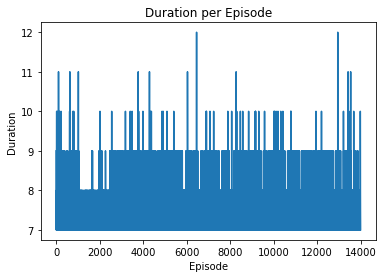

In [33]:
plt.plot(np.arange(len(episode_durations_durations_durations)), episode_durations)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Duration per Episode')
plt.show()

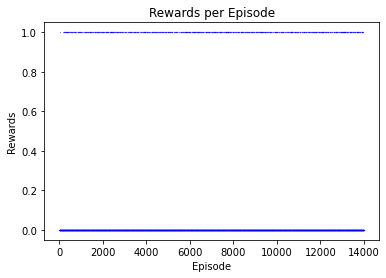

In [37]:
plt.plot(np.arange(len(rewards)), rewards, 'bo', markersize=0.1)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards per Episode')
plt.show()